In [1]:
import numpy as np
import pandas as pd
import pickle
import sys, os
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.special import softmax
from scipy import spatial
from numpy import dot
from numpy.linalg import norm
from matplotlib.gridspec import GridSpec

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
print(module_path)

from explainability_analysis.visualization_functions import * 
from explainability_analysis.transformer_analysis import *
from explainability_analysis.util import *

num_classes = 12

home_path = str(Path.home())

model_root_path = os.path.join(home_path, "EO_explainability_survey/training_results/bavarian_crops/pos_enc_obs_date/{}_classes/".format(num_classes))

aggregation_method = "weekly_average"

predictions_path = os.path.join(model_root_path, aggregation_method, "predictions")
predictions = np.loadtxt(os.path.join(predictions_path, "predicted_vs_true.csv"), skiprows = 1, delimiter = ",", dtype = np.uint)

ndvi_indices_weekly_level = pd.read_csv(os.path.join(predictions_path, "WEEK_NDVI.csv"), index_col="CLASS")
ndvi_indices_weekly_level = ndvi_indices_weekly_level.sort_values('CLASS')

attn_weights_root_dir = os.path.join(predictions_path, "attn_weights")

attention_weights_vs_crop_phenology = os.path.join(predictions_path, "relating_attn_weights_to_crop_phenology")

if not os.path.exists(attention_weights_vs_crop_phenology):
    os.makedirs(attention_weights_vs_crop_phenology)
    
confusion_matrix = pd.read_csv(os.path.join(predictions_path, "confusion_matrix.csv"))
class_names = list(confusion_matrix.columns.values)

C:\Users\Ivica Obadic\PycharmProjects\EOExplainability


In [ ]:
avg_attn_weights_per_class, sd_attn_weights_per_class = get_avg_attn_weights_and_sd(
    attn_weights_root_dir,
    predictions,
    class_names,
    reduction="head_time_point")
avg_attn_weights_per_class_dfs = convert_attn_weight_dict_to_df(avg_attn_weights_per_class)
sd_attn_weights_per_class_dfs = convert_attn_weight_dict_to_df(sd_attn_weights_per_class)

In [ ]:
corn_avg_total_weights = avg_attn_weights_per_class_dfs["corn"]
corn_sd_total_weights = sd_attn_weights_per_class_dfs["corn"]

grassland_avg_total_weights = avg_attn_weights_per_class_dfs["grassland"]
grassland_sd_total_weights = sd_attn_weights_per_class_dfs["grassland"]

winter_rye_avg_total_weights = avg_attn_weights_per_class_dfs["winter rye"]
winter_rye_sd_total_weights = sd_attn_weights_per_class_dfs["winter rye"]

winter_wheat_avg_total_weights = avg_attn_weights_per_class_dfs["winter wheat"]

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(13, 8))

ax_corn_left = sns.heatmap(corn_avg_total_weights, cmap = "Blues", ax=axs[0][0])
ax_corn_left.tick_params(axis='x', labelsize=8)
ax_corn_left.tick_params(axis='y', labelsize=6)
ax_corn_left.set_title("Average total temporal attention - Corn", fontsize=10)
ax_corn_right = sns.heatmap(grassland_avg_total_weights, cmap = "Greens", ax=axs[0][1])
ax_corn_right.tick_params(axis='x', labelsize=8)
ax_corn_right.tick_params(axis='y', labelsize=6)
ax_corn_right.set_title("Average total temporal attention - Grassland", fontsize=10)

ax_grassland_left = sns.heatmap(winter_rye_avg_total_weights, cmap = "Oranges", ax=axs[1][0])
ax_grassland_left.set_title("Average total temporal attention - Winter Rye",fontsize=10)
ax_grassland_left.tick_params(axis='x', labelsize=8)
ax_grassland_left.tick_params(axis='y', labelsize=6)
ax_grassland_right = sns.heatmap(winter_wheat_avg_total_weights, cmap = "Reds", ax=axs[1][1])
ax_grassland_right.tick_params(axis='x', labelsize=8)
ax_grassland_right.tick_params(axis='y', labelsize=6)
ax_grassland_right.set_title("Average total temporal attention - Winter Wheat", fontsize=10)
fig.tight_layout()
#ax_winter_rye_left = sns.heatmap(winter_rye_avg_total_weights, cmap = "Blues", ax=axs[2][0])
#ax_winter_rye_left.set_title("Average total temporal attention - Winter Rye")
#ax_winter_rye_right = sns.heatmap(winter_rye_sd_total_weights, cmap = "Greens", ax=axs[2][1])
#ax_winter_rye_right.set_title("SD total temporal attention - Winter Rye")

In [2]:
avg_attn_weights_per_class, sd_attn_weights_per_class = get_avg_attn_weights_and_sd(
    attn_weights_root_dir,
    predictions,
    class_names,
    reduction="time_point",
    norm_fn="min_max")

avg_attn_weights_per_class_df = pd.DataFrame.from_dict(
            avg_attn_weights_per_class,
            orient="index",
            columns=timeframe_columns)
avg_attn_weights_per_class_df.index.name = 'CLASS'
avg_attn_weights_per_class_df = avg_attn_weights_per_class_df.sort_values('CLASS')

sd_attn_weights_per_class_df = pd.DataFrame.from_dict(
            sd_attn_weights_per_class,
            orient="index",
            columns=timeframe_columns)
sd_attn_weights_per_class_df.index.name = 'CLASS'

#ndvi_indices_weekly_level["TYPE"] = "NDVI"
#avg_attn_weights_per_class_df["TYPE"] = "AVG_TEMP_ATTN_WEIGHTS"
all_data = ndvi_indices_weekly_level.copy()
all_data["TYPE"] = "NDVI"

avg_attn_weights_copy = avg_attn_weights_per_class_df.copy()
avg_attn_weights_copy["TYPE"] = "AVG_TEMP_ATTN_WEIGHTS"

all_data = pd.concat([all_data, avg_attn_weights_copy]).reset_index()
all_data = pd.melt(all_data, id_vars=["CLASS", "TYPE"], var_name="Week", value_name="Value")

def cosine_sim(crop_type_data):
    ndvi_values = crop_type_data[crop_type_data["TYPE"] == "NDVI"]["Value"].to_numpy()
    avg_attn_weights_values = crop_type_data[crop_type_data["TYPE"] == "AVG_TEMP_ATTN_WEIGHTS"]["Value"].to_numpy()
    
    return dot(ndvi_values, avg_attn_weights_values)/(norm(ndvi_values)*norm(avg_attn_weights_values))

crop_type_cos_sim = all_data.groupby("CLASS").apply(cosine_sim).to_frame()

[0.         0.00145328 0.00133731 0.00348816 0.00356729 0.01067606
 0.01737571 0.34604108 0.03127629 0.04849845 0.00884798 0.01468474
 0.00550813 0.50435764 0.31982028 0.3187341  0.53125143 0.52745515
 0.6493958  0.03968449 0.4244713  0.1935158  0.7370865  0.04689087
 0.17554116 0.03836649 0.47210062 0.02842733 0.02357225 0.8395088
 1.         0.0172228  0.22941256 0.007644   0.00351545 0.26400566
 0.11723374 0.29277205 0.10650539 0.19970484 0.25227278 0.05253954
 0.04689485 0.00907559 0.01131024 0.21736455 0.01694177 0.02949284
 0.00229679 0.01867293 0.00171511 0.06356797]
[0.0000000e+00 2.7948413e-03 4.9909763e-04 2.2745710e-03 1.2401529e-03
 9.0279169e-03 1.5257981e-02 2.6088589e-01 4.6098307e-02 1.1423018e-01
 2.3570381e-02 5.2647457e-02 7.3028542e-03 4.8249558e-01 1.7084599e-01
 4.1490892e-01 4.1361818e-01 6.1150074e-01 7.3655677e-01 3.7272509e-02
 3.2912594e-01 2.2837213e-01 9.0307069e-01 1.0841332e-01 1.7674270e-01
 7.5612031e-02 4.7353640e-01 6.1721042e-02 1.1709168e-01 7.93570

                  2018-01-01  2018-01-08  2018-01-15  2018-01-22  2018-01-29  \
CLASS                                                                          
corn                0.001691    0.003890    0.001202    0.002680    0.001531   
fallow              0.000000    0.001453    0.001337    0.003488    0.003567   
grassland           0.000000    0.002795    0.000499    0.002275    0.001240   
rapeseed            0.001708    0.003353    0.000000    0.001313    0.000934   
summer barley       0.000832    0.001540    0.000888    0.004394    0.003881   
summer oat          0.000000    0.001795    0.001042    0.003779    0.002687   
summer wheat        0.000000    0.001394    0.001773    0.004200    0.002403   
winter barley       0.000514    0.002847    0.000000    0.002298    0.001534   
winter rye          0.000000    0.000866    0.000219    0.002911    0.003105   
winter spelt        0.000277    0.004472    0.000000    0.001769    0.001235   
winter triticale    0.000000    0.002244

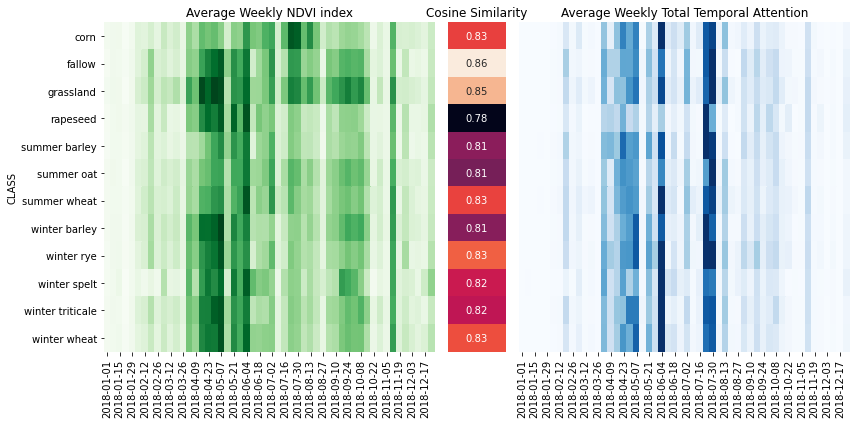

In [6]:

fig, axs = plt.subplots(ncols=3, figsize=(12, 6), gridspec_kw={'width_ratios': [4, 0.7, 4]})

ax_ndvi_index = sns.heatmap(ndvi_indices_weekly_level, cmap = "Greens", ax=axs[0], cbar=False)
ax_ndvi_index.set_title("Average Weekly NDVI index", fontsize=12)

ax_cosine_sim = sns.heatmap(crop_type_cos_sim, cbar=False, ax=axs[1], annot=True, yticklabels=False, xticklabels=False)
ax_cosine_sim.set_ylabel('')    
ax_cosine_sim.set_xlabel('')
ax_cosine_sim.set_title('Cosine Similarity')

ax_attn_weights = sns.heatmap(avg_attn_weights_per_class_df, cmap = "Blues", ax=axs[2], yticklabels=False, cbar=False)
ax_attn_weights.set_title("Average Weekly Total Temporal Attention", fontsize=12)
ax_attn_weights.set_ylabel('')    


fig.tight_layout()

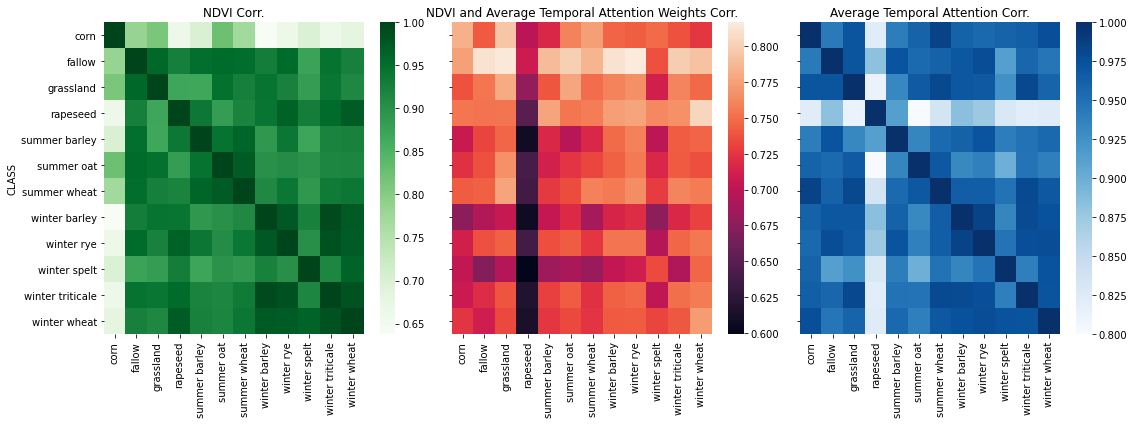

In [34]:
avg_attn_weights_np = avg_attn_weights_per_class_df.to_numpy()
ndvi_index_np = ndvi_indices_weekly_level.to_numpy()
ndvi_index_corr = pd.DataFrame(np.corrcoef(ndvi_index_np), index=ndvi_indices_weekly_level.reset_index()["CLASS"])
avg_attn_weights_corr = pd.DataFrame(np.corrcoef(avg_attn_weights_np), index=ndvi_indices_weekly_level.reset_index()["CLASS"])
ndvi_avg_attn_weights_corr = np.corrcoef(ndvi_index_np, avg_attn_weights_np)[0:12,12:]
ndvi_avg_attn_weights_corr = pd.DataFrame(ndvi_avg_attn_weights_corr, index=ndvi_indices_weekly_level.reset_index()["CLASS"])

fig, axs = plt.subplots(ncols=3, figsize=(16, 6), sharey=True)

ax_ndvi_index = sns.heatmap(ndvi_index_corr, cmap = "Greens", ax=axs[0], xticklabels = ndvi_indices_weekly_level.reset_index()["CLASS"])
ax_ndvi_index.set_title("NDVI Corr.", fontsize=12)

ax_cosine_sim = sns.heatmap(ndvi_avg_attn_weights_corr, ax=axs[1], xticklabels = ndvi_indices_weekly_level.reset_index()["CLASS"])
ax_cosine_sim.set_ylabel('')    
ax_cosine_sim.set_xlabel('')
ax_cosine_sim.set_title('NDVI and Average Temporal Attention Weights Corr.')

ax_attn_weights = sns.heatmap(avg_attn_weights_corr, cmap = "Blues", ax=axs[2], xticklabels = ndvi_indices_weekly_level.reset_index()["CLASS"])
ax_attn_weights.set_title("Average Temporal Attention Corr.", fontsize=12)
ax_attn_weights.set_ylabel('')    


fig.tight_layout()

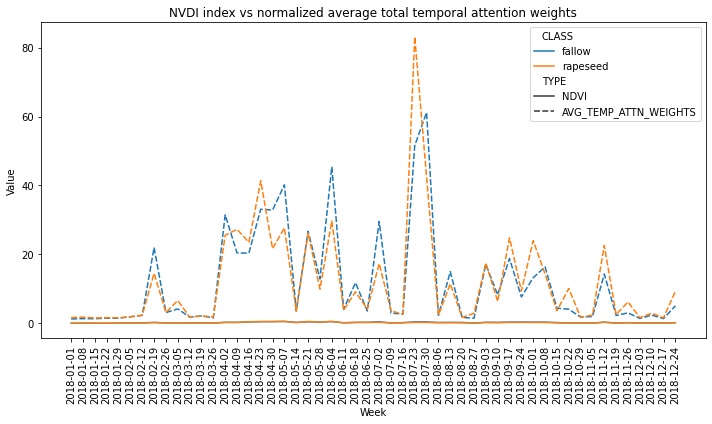

In [6]:
target_classes = ["fallow", "rapeseed"]
plot_data = all_data[all_data["CLASS"].isin(target_classes)]
fig, axs = plt.subplots(ncols=1, figsize=(10, 6))
sns.lineplot(x="Week", y="Value", data=plot_data, hue="CLASS", style="TYPE")
axs.set_title("NVDI index vs normalized average total temporal attention weights")
plt.xticks(rotation=90)
fig.tight_layout()

In [ ]:
visualize_attention_by_layer(
    'layer_0',
    avg_attn_weights_in_time_frame,
    sd_attn_weights_in_time_frame,
    'Attention weights for period 2018-01-01 - 2018-01-29',
    'Average Attention Weights',
    'Standard Deviation of the Attention Weights',
    class_labels)

In [ ]:
visualize_attention_by_layer(
    'layer_1',
     avg_attn_weights_in_time_frame,
    sd_attn_weights_in_time_frame,
    'Attention weights for period 2018-01-01 - 2018-01-29',
    'Average Attention Weights',
    'Standard Deviation of the Attention Weights',
    class_labels)

In [ ]:
visualize_attention_by_layer(
    'layer_2',
    avg_attn_weights_in_time_frame,
    sd_attn_weights_in_time_frame,
    'Attention weights for period 2018-01-01 - 2018-01-29',
    'Average Attention Weights',
    'Standard Deviation of the Attention Weights',
    class_labels)

In [ ]:
accuracies = dict()
per_class_accuracies = dict()
plotting_data_for_conf = dict()
for layer in ["layer_0", "layer_1", "layer_2"]:
    for head_idx in range(4):
        parcels_ids, feature_embeddings_for_l_h = summarize_attention_weights_as_feature_embeddings(attn_weights_root_dir, layer, head_idx)
        label_ids_for_parcels = get_labels_for_parcel_ids(parcels_ids, predictions_path, return_names=False)
        label_names_for_parcels = get_labels_for_parcel_ids(parcels_ids, predictions_path)
        result_key = layer + ", head_{}".format(head_idx)
        accuracy, per_class_accuracy, plotting_data = cluster_and_evaluate_attention_features(
            feature_embeddings_for_l_h,
            label_names_for_parcels,
            label_ids_for_parcels,
            num_classes,
            result_key,
            attention_weights_vs_crop_phenology)
        accuracies[result_key] = accuracy
        per_class_accuracies[result_key] = per_class_accuracy
        plotting_data_for_conf[result_key] = plotting_data

In [ ]:
parcels_ids, concatenated_attention_features = summarize_attention_weights_as_feature_embeddings(attn_weights_root_dir, "all", -1)
label_names_for_parcels = get_labels_for_parcel_ids(parcels_ids, predictions_path)
label_ids_for_parcels = get_labels_for_parcel_ids(parcels_ids, predictions_path, return_names=False)
global_accuracy, global_per_class_accuracy, global_plotting_data = cluster_and_evaluate_attention_features(
    concatenated_attention_features,
    label_names_for_parcels,
    label_ids_for_parcels,
    num_classes,
    "all_layers_and_heads",
    attention_weights_vs_crop_phenology)

In [ ]:
clustering_goodness_of_fit = []
for configuration in per_class_accuracies.keys():
    total_accuracy = "{:.2f}".format(accuracies[configuration])
    clusters_class_level_accuracies = per_class_accuracies[configuration]
    average_accuracy_per_class = "{:.2f}".format(clusters_class_level_accuracies.mean())
    top_3_classes_labels = np.argsort(-1*clusters_class_level_accuracies)[:3]
    top_3_classes_names = [class_names[label].upper() for label in top_3_classes_labels]
    top_3_classes_with_accuracy = []
    for i in range(len(top_3_classes)):
        class_accuracy = clusters_class_level_accuracies[top_3_classes_labels[i]]
        top_3_classes_with_accuracy.append("{}:{:.2f}".format(top_3_classes_names[i], class_accuracy))
    
    clustering_goodness_of_fit.append((configuration, total_accuracy, average_accuracy_per_class, ", ".join(top_3_classes_with_accuracy)))

global_accuracy =  "{:.2f}".format(global_accuracy) 
global_class_level_accuracy = "{:.2f}".format(global_per_class_accuracy.mean())
top_3_global_classes_labels = np.argsort(-1*global_per_class_accuracy)[:3]
top_3_global_classes_names = [class_names[label].upper() for label in top_3_global_classes_labels]
top_3_global_classes_with_accuracy = []
for i in range(len(top_3_global_classes_labels)):
    global_class_accuracy = global_per_class_accuracy[top_3_global_classes_labels[i]]
    top_3_global_classes_with_accuracy.append("{}:{:.2f}".format(top_3_global_classes_names[i], global_class_accuracy))

clustering_goodness_of_fit.append(("all_layers_and_heads", global_accuracy, global_class_level_accuracy, ", ".join(top_3_global_classes_with_accuracy)))

results_as_pd = pd.DataFrame(clustering_goodness_of_fit, columns = ["Feature Source", "Cluster Accuracy", "Average Cluster Accuracy per Class", "Top-3-Classes"])
results_as_pd

In [ ]:
fig, ax1 = plt.subplots(figsize=(8, 7))
ax = sns.scatterplot(data=global_plotting_data, x="TSNE_DIM_1", y="TSNE_DIM_2", hue="CLASS_NAME", style="CLUSTER", palette="Paired")
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
ax.set_title("Crop-Types Clustering based on the Attention Weights Temporal Signal", fontsize=12)